# League of Legends Data Analysis - Research Notebook

This notebook collects experiments, figures, code snippets, and notes to track evolution of the project for the thesis.

- Project: Data analysis of League of Legends matches
- Author: Speazyy
- Goal: Build analyses (KDA, gold, damage, items, win rates, movement heatmaps) and document iterations.

---

## Index
- Setup
- Data sources and artifacts
- Experiments
  - E1: Analyze single match (KDA, Gold, Damage, Items)
  - E2: Item names via Data Dragon
  - E3: Player movement heatmaps with names
  - E4: Player win/loss by side (blue/red)
  - E5: Champion and player winrates (multi-match)
- Findings and next steps


In [1]:
# Setup: common imports and helpers
import os, json, time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from dotenv import load_dotenv

load_dotenv()

# Utility: pretty print JSON subset
def jprint(obj, maxlen=800):
    s = json.dumps(obj, indent=2)[:maxlen]
    print(s + ("..." if len(s) == maxlen else ""))

In [2]:
# Versioning config: date-based run stamp and experiment version tags
from datetime import datetime, timezone

# ISO date for today (UTC). Use in figure titles and logs.
NOTEBOOK_RUN_DATE = datetime.now(timezone.utc).date().isoformat()
# High-resolution timestamp for unique filenames per run
RUN_STAMP = datetime.now(timezone.utc).strftime("%Y-%m-%d_%H-%M-%S")

# Experiment version tags (bump when logic/visuals change)
E1_VERSION = globals().get("E1_VERSION", "v1.1")  # redesigned seaborn visual suite
E2_VERSION = globals().get("E2_VERSION", "v1.0")
E3_VERSION = globals().get("E3_VERSION", "v1.0")
E4_VERSION = globals().get("E4_VERSION", "v1.2")  # replaced pie with comparative bars + proportions
E5_VERSION = globals().get("E5_VERSION", "v0.1")  # placeholder

In [3]:
# Figure saving utility
from pathlib import Path
from typing import Optional

FIG_ROOT = Path.cwd() / "figures"
FIG_ROOT.mkdir(parents=True, exist_ok=True)

def save_fig(fig, filename: str, subdir: Optional[str] = None, dpi: int = 200):
    """Save a matplotlib figure under figures/[subdir]/filename and return the path.
    filename should include extension (e.g., .png). Automatically creates folders.
    """
    out_dir = FIG_ROOT if not subdir else FIG_ROOT / subdir
    out_dir.mkdir(parents=True, exist_ok=True)
    out_path = out_dir / filename
    fig.savefig(out_path.as_posix(), dpi=dpi, bbox_inches='tight')
    print(f"Saved figure: {out_path}")
    return out_path.as_posix()

In [4]:
# Helper: display saved figures for a given experiment (e.g., 'E1')
from IPython.display import display, Image, Markdown

def display_experiment_images(exp: str, prefix: str = None):
    p = FIG_ROOT / exp
    if not p.exists():
        display(Markdown(f"No saved figures for `{exp}` (folder `{p}` not found)."))
        return
    files = sorted([f for f in p.iterdir() if f.suffix.lower() in {'.png', '.jpg', '.jpeg'}])
    if prefix:
        files = [f for f in files if f.name.startswith(prefix)]
    if not files:
        display(Markdown(f"No images found for `{exp}`."))
        return
    display(Markdown(f"#### {exp} saved figures"))
    for f in files:
        display(Markdown(f"**{f.name}**"))
        display(Image(filename=f.as_posix()))

## Data sources and artifacts

- Matches info JSON: `arutnevjr_ajr_matches_info.json`
- Timeline & map: `fetch_api_timeline.py`, `lol_map.png`
- Player movement extraction: `extract_positions.py`
- Match analysis: `analyze_match.py`
- Win/loss by side: `fetch_player_winloss_side.py`, `plot_player_winloss_side.py`
- Helpers: `helper.py`, `lookup.py`, `summoner_list.py`

### E1: Single match analysis (KDA, Gold, Damage, Items)
Goal: Reproduce and iterate on the analyses from `analyze_match.py` (KDA, average gold per team, average damage taken, most used items).

Note: Each experiment title includes the run date (UTC) and a semantic version tag (e.g., E1 v1.0). Increase the version when logic or visuals change.

In [ ]:
# Display E1 figures (all versions present in figures/E1)
display_experiment_images('E1', prefix='E1_')

Saved figure: c:\Users\Speazyy\Documents\Faculdade\Mestrado\Tese\Dataset project\LoL-dataset\figures\E1\E1_v1.0_2025-08-13_KDA.png


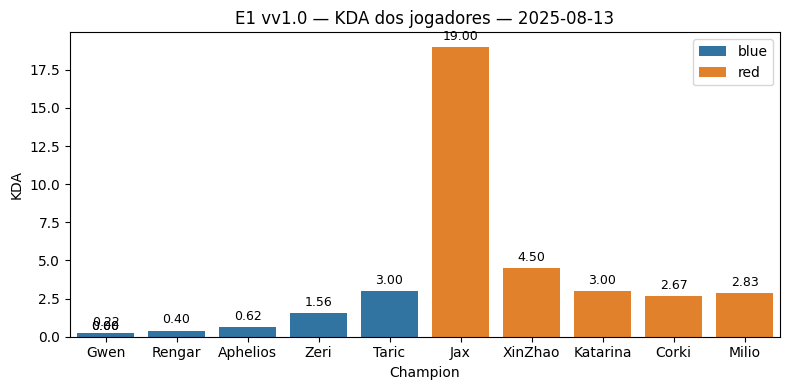

Saved figure: c:\Users\Speazyy\Documents\Faculdade\Mestrado\Tese\Dataset project\LoL-dataset\figures\E1\E1_v1.0_2025-08-13_AvgGold.png


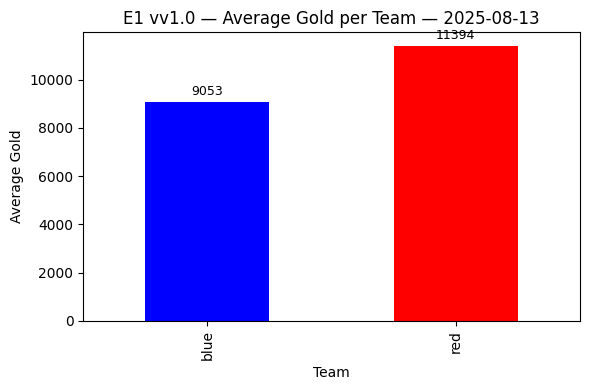

Saved figure: c:\Users\Speazyy\Documents\Faculdade\Mestrado\Tese\Dataset project\LoL-dataset\figures\E1\E1_v1.0_2025-08-13_AvgDamageTaken.png


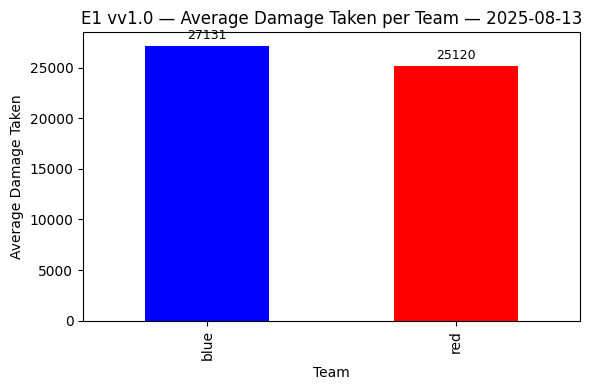

Saved figure: c:\Users\Speazyy\Documents\Faculdade\Mestrado\Tese\Dataset project\LoL-dataset\figures\E1\E1_v1.0_2025-08-13_MostUsedItems.png


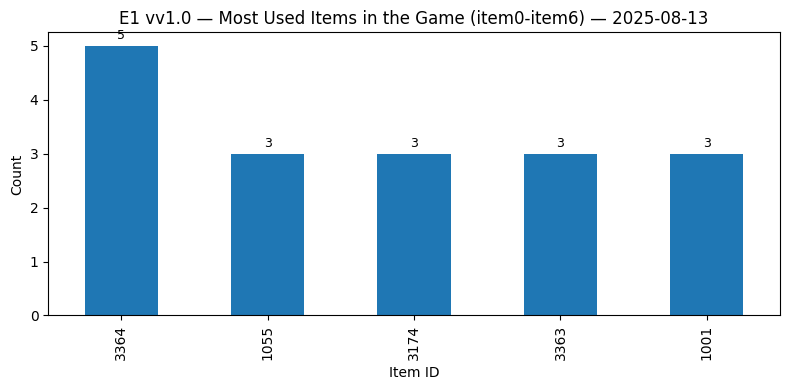

In [ ]:
# Load match info and build DataFrame like analyze_match.py (visual redesign v1.1)
with open("arutnevjr_ajr_matches_info.json", "r") as f:
    matches_info = json.load(f)
match = matches_info[0]

item_cols = [f"item{i}" for i in range(7)]
item_data = {col: [match["items"][i][j] if j < len(match["items"][i]) else 0 for i in range(len(match["items"]))] for j, col in enumerate(item_cols)}

df = pd.DataFrame({
    "champion": match["picks"],
    "position": match["position"],
    "team": match["teams"],
    "kills": match["kills"],
    "deaths": match["deaths"],
    "assists": match["assists"],
    "gold": match["gold"],
    "win": match["win"],
    **item_data
})

# Derived metrics
df["KDA"] = (df["kills"] + df["assists"]) / df["deaths"].replace(0, 1)

def annotate_bar(ax, fmt="{:.2f}"):
    for p in ax.patches:
        if p.get_height() > 0:
            ax.annotate(fmt.format(p.get_height()),
                        (p.get_x() + p.get_width()/2., p.get_height()),
                        ha='center', va='bottom', fontsize=8, xytext=(0,3), textcoords='offset points')

sns.set_theme(style="whitegrid", context="notebook")
palette_team = {"blue": "#4A90E2", "red": "#E94B3C"}

# 1. KDA: better shown as sorted horizontal bar for readability
kda_order = df.sort_values("KDA", ascending=True)
plt.figure(figsize=(8,5))
ax = sns.barplot(data=kda_order, x="KDA", y="champion", hue="team", palette=palette_team, dodge=False)
plt.title(f"E1 {E1_VERSION} — Player KDA (sorted) — {NOTEBOOK_RUN_DATE}")
plt.xlabel("KDA")
plt.ylabel("Champion")
for c in ax.containers:
    ax.bar_label(c, fmt='%.2f', padding=3, fontsize=8)
plt.legend(title="Team")
plt.tight_layout()
save_fig(plt.gcf(), f"E1_{E1_VERSION}_{NOTEBOOK_RUN_DATE}_KDA.png", subdir="E1")
plt.show()

# 2. Gold distribution: show team comparison with violin + swarm (granular + distribution)
plt.figure(figsize=(8,5))
ax = sns.violinplot(data=df, x="team", y="gold", inner=None, palette=palette_team)
sns.swarmplot(data=df, x="team", y="gold", hue="win", dodge=True, size=6, palette={True:"#2e7d32", False:"#b71c1c"})
plt.title(f"E1 {E1_VERSION} — Gold Distribution per Team (violin + swarm) — {NOTEBOOK_RUN_DATE}")
plt.xlabel("Team")
plt.ylabel("Gold")
plt.legend(title="Win", bbox_to_anchor=(1.05,1), loc='upper left')
plt.tight_layout()
save_fig(plt.gcf(), f"E1_{E1_VERSION}_{NOTEBOOK_RUN_DATE}_GoldDistribution.png", subdir="E1")
plt.show()

# 3. Damage taken (if present): use grouped bar with mean labels
if "damageTaken" in match:
    df["damageTaken"] = match["damageTaken"]
    dmg_summary = df.groupby("team")["damageTaken"].agg(['mean','min','max']).reset_index()
    plt.figure(figsize=(6,5))
    ax = sns.barplot(data=dmg_summary, x="team", y="mean", palette=palette_team)
    annotate_bar(ax, fmt="{:.0f}")
    for i,row in dmg_summary.iterrows():
        ax.text(i, row['mean']*0.02, f"min {row['min']:.0f}\nmax {row['max']:.0f}", ha='center', va='bottom', fontsize=8, color='#333')
    plt.title(f"E1 {E1_VERSION} — Damage Taken (mean/min/max) — {NOTEBOOK_RUN_DATE}")
    plt.xlabel("Team")
    plt.ylabel("Damage Taken (mean)")
    plt.tight_layout()
    save_fig(plt.gcf(), f"E1_{E1_VERSION}_{NOTEBOOK_RUN_DATE}_DamageTaken.png", subdir="E1")
    plt.show()

# 4. Item usage: horizontal bar of top items (frequency)
items = []
for col in item_cols:
    items.extend(df[col].tolist())
items = [item for item in items if item != 0]
item_counts = pd.Series(items).value_counts().head(10)[::-1]  # reverse for horizontal
plt.figure(figsize=(7,5))
ax = sns.barplot(x=item_counts.values, y=item_counts.index, color="#6a5acd")
for i, v in enumerate(item_counts.values):
    ax.text(v+0.1, i, str(v), va='center', fontsize=8)
plt.title(f"E1 {E1_VERSION} — Top Item IDs (frequency) — {NOTEBOOK_RUN_DATE}")
plt.xlabel("Count")
plt.ylabel("Item ID")
plt.tight_layout()
save_fig(plt.gcf(), f"E1_{E1_VERSION}_{NOTEBOOK_RUN_DATE}_TopItems.png", subdir="E1")
plt.show()

### E2: Item name mapping via Data Dragon
Goal: Map item IDs to human-readable names using Riot Data Dragon item dataset.

Note: E2 figures/code will include the run date and E2 version. Next step: integrate item names into `analyze_match.py` visualizations.

In [ ]:
# Display E2 figures (if any exist yet)
display_experiment_images('E2', prefix='E2_')

In [ ]:
# E2: Example item name mapping plot (timestamped file)
# If items.json exists, show top 10 item names from a sample list
try:
    with open("items.json", "r", encoding="utf-8") as f:
        items_dd = json.load(f)
    id_to_name = {int(k): v.get("name", str(k)) for k, v in items_dd.get("data", {}).items()}

    # For demo, reuse E1 item frequency if available, else synthesize a small list
    try:
        from collections import Counter
        # Attempt to read an E1 file output to infer item IDs (optional)
        # Fallback: a small sample
        sample_item_ids = [1001, 2003, 1055, 1036, 6672, 6673, 6671, 3031, 3036, 3006]
        item_names = [id_to_name.get(i, str(i)) for i in sample_item_ids]
        counts = Counter(item_names)
        names, vals = zip(*counts.items())
        plt.figure(figsize=(8,4))
        ax = sns.barplot(x=list(vals), y=list(names), color="#6a5acd")
        for i, v in enumerate(vals):
            ax.text(v+0.1, i, str(v), va='center', fontsize=8)
        plt.title(f"E2 {E2_VERSION} — Sample Item Names — {NOTEBOOK_RUN_DATE}")
        plt.xlabel("Count")
        plt.ylabel("Item Name")
        plt.tight_layout()
        save_fig(plt.gcf(), f"E2_{E2_VERSION}_{RUN_STAMP}_SampleItemNames.png", subdir="E2")
        plt.show()
    except Exception as e:
        print("E2 plotting error:", e)
except FileNotFoundError:
    print("items.json not found. Place Data Dragon items JSON as items.json in project root.")

items.json not found. Place Data Dragon items JSON in the project root as items.json.


### E3: Movement heatmaps with player names
Goal: Ensure heatmap captions and titles include correct player names (participantId/puuid mapping from match info). Add snapshots and notes here when generated.

Note (E3 v1.1 — {NOTEBOOK_RUN_DATE}): `extract_positions.py` now loads the Riot API key from `.env` (load_dotenv(override=True)), removes the debug print, and saves per-player heatmaps to `figures/E3/` with date/versioned filenames. If you see CJK glyph warnings in titles, consider setting a font that supports CJK (e.g., matplotlib.rcParams['font.family'] = 'Noto Sans CJK SC']).

In [ ]:
# Display E3 figures (movement heatmaps)
display_experiment_images('E3', prefix='E3_')

### E4: Win/Loss by side (Blue/Red)
Goal: Fetch last N matches, compute wins/losses by side, visualize as a pie chart. The JSON now stores summoner and results.

Saved figure: c:\Users\Speazyy\Documents\Faculdade\Mestrado\Tese\Dataset project\LoL-dataset\figures\E4\E4_v1.2_2025-09-23_21-14-50_arutnevjr_ajr_CountBySideWin.png


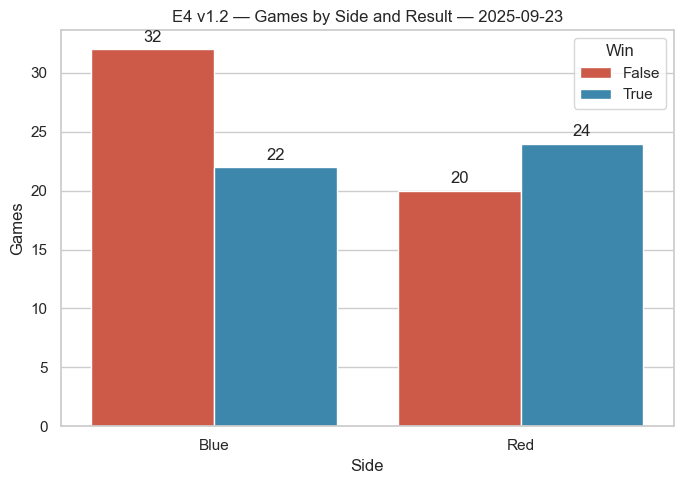

Saved figure: c:\Users\Speazyy\Documents\Faculdade\Mestrado\Tese\Dataset project\LoL-dataset\figures\E4\E4_v1.2_2025-09-23_21-14-50_arutnevjr_ajr_WinrateBar_CI.png


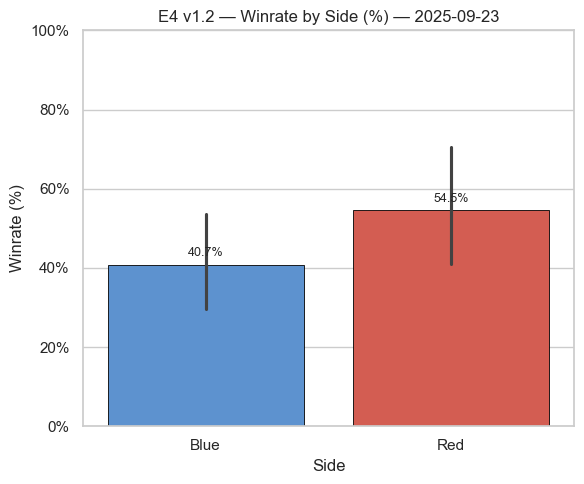

Saved figure: c:\Users\Speazyy\Documents\Faculdade\Mestrado\Tese\Dataset project\LoL-dataset\figures\E4\E4_v1.2_2025-09-23_21-14-50_arutnevjr_ajr_WinratePoint_CI.png


C:\Temp\ipykernel_13088\1693089027.py:59: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  ax = sns.pointplot(data=df, x='side', y='win_num', errorbar=('ci',95), join=False, color='#333', markers='o')


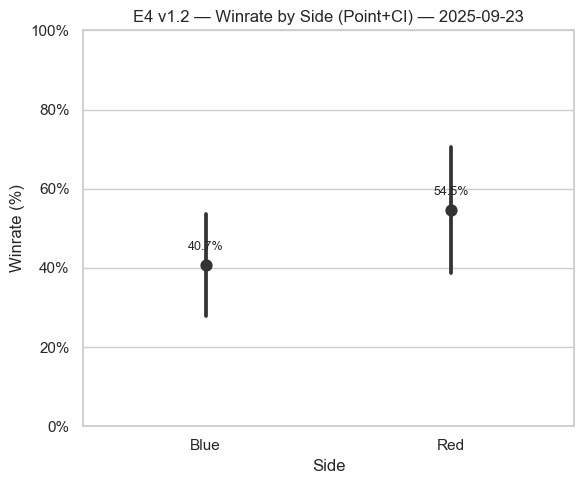

In [6]:
# E4: Seaborn optimal plots — countplot and CI-based winrate charts
import json, numpy as np, pandas as pd, seaborn as sns, matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

with open("player_winloss_side.json", "r") as f:
    json_data = json.load(f)

SUMMONER_NAME = json_data.get("summoner_name", "?")
TAGLINE = json_data.get("tagline", "?")
results = json_data.get("results", [])

if not results:
    print("No results in player_winloss_side.json")
else:
    df = pd.DataFrame(results)
    # Normalize side labels and create numeric win column
    df['side'] = df['side'].str.capitalize()
    df['win_num'] = df['win'].astype(int)

    sns.set_theme(style="whitegrid", context="notebook")

    # 1) Countplot: Games by side and result
    plt.figure(figsize=(7,5))
    ax = sns.countplot(
        data=df, x='side', hue='win', dodge=True,
        palette={True: '#2b8cbe', False: '#e34a33'},
        order=sorted(df['side'].unique())
    )
    plt.title(f"E4 {E4_VERSION} — Games by Side and Result — {NOTEBOOK_RUN_DATE}")
    plt.xlabel("Side"); plt.ylabel("Games")
    for c in ax.containers:
        ax.bar_label(c, fmt='%d', padding=3)
    ax.legend(title="Win", frameon=True)
    plt.tight_layout()
    save_fig(plt.gcf(), f"E4_{E4_VERSION}_{RUN_STAMP}_{SUMMONER_NAME}_{TAGLINE}_CountBySideWin.png", subdir="E4")
    plt.show()

    # 2) Winrate bar with 95% CI
    plt.figure(figsize=(6,5))
    ax = sns.barplot(
        data=df, x='side', y='win_num', estimator=np.mean,
        errorbar=('ci', 95),
        hue='side', palette={'Blue': '#4a90e2', 'Red': '#e94b3c'},
        dodge=False, edgecolor='black', linewidth=0.6, legend=False
    )
    ax.set_title(f"E4 {E4_VERSION} — Winrate by Side (%) — {NOTEBOOK_RUN_DATE}")
    ax.set_xlabel("Side"); ax.set_ylabel("Winrate (%)")
    ax.set_ylim(0, 1)
    ax.yaxis.set_major_formatter(PercentFormatter(1.0))
    for p in ax.patches:
        h = p.get_height()
        ax.annotate(f"{h*100:.1f}%", (p.get_x()+p.get_width()/2., h), ha='center', va='bottom', fontsize=9, xytext=(0,4), textcoords='offset points')
    plt.tight_layout()
    save_fig(plt.gcf(), f"E4_{E4_VERSION}_{RUN_STAMP}_{SUMMONER_NAME}_{TAGLINE}_WinrateBar_CI.png", subdir="E4")
    plt.show()

    # 3) Winrate point plot with 95% CI
    plt.figure(figsize=(6,5))
    ax = sns.pointplot(data=df, x='side', y='win_num', errorbar=('ci',95), join=False, color='#333', markers='o')
    ax.set_title(f"E4 {E4_VERSION} — Winrate by Side (Point+CI) — {NOTEBOOK_RUN_DATE}")
    ax.set_xlabel("Side"); ax.set_ylabel("Winrate (%)")
    ax.set_ylim(0, 1)
    ax.yaxis.set_major_formatter(PercentFormatter(1.0))
    means = df.groupby('side')['win_num'].mean()
    for i, side in enumerate(sorted(df['side'].unique())):
        m = means.loc[side]
        ax.text(i, m + 0.03, f"{m*100:.1f}%", ha='center', va='bottom', fontsize=9)
    plt.tight_layout()
    save_fig(plt.gcf(), f"E4_{E4_VERSION}_{RUN_STAMP}_{SUMMONER_NAME}_{TAGLINE}_WinratePoint_CI.png", subdir="E4")
    plt.show()

#### Saved figures and embedding
All plots are saved under `figures/<Experiment>/...png` with date/version in the filename. The gallery below auto-embeds saved figures if present.

#### E4 saved figures

**E4_script_2025-08-13_arutnevjr_ajr_Pie.png**

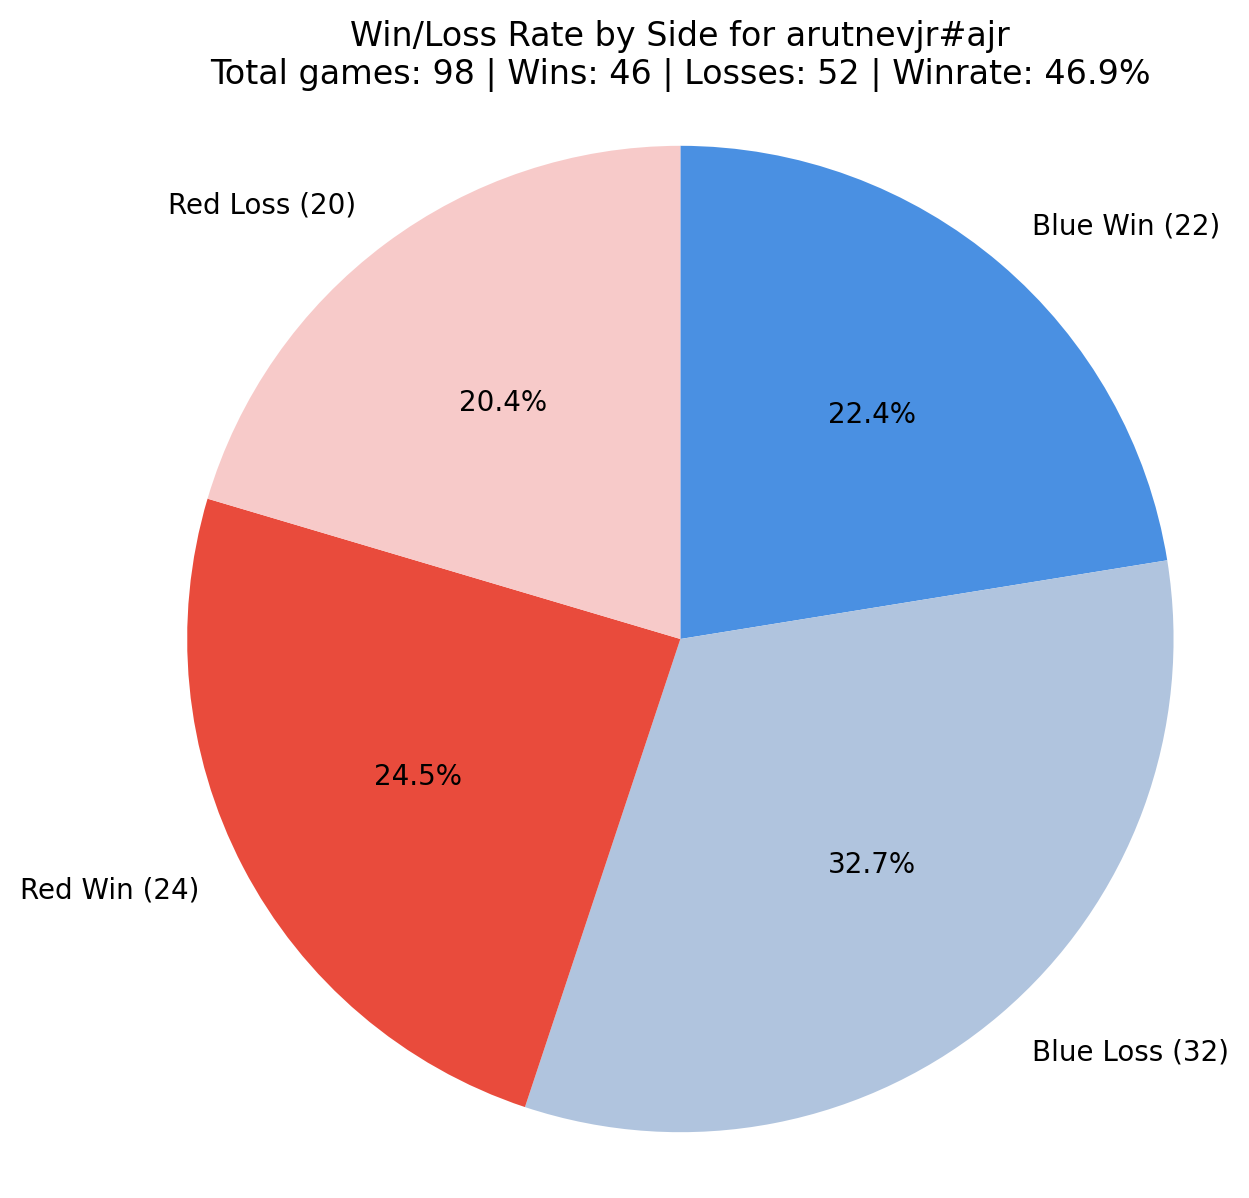

**E4_script_2025-09-13_arutnevjr_ajr_Donut.png**

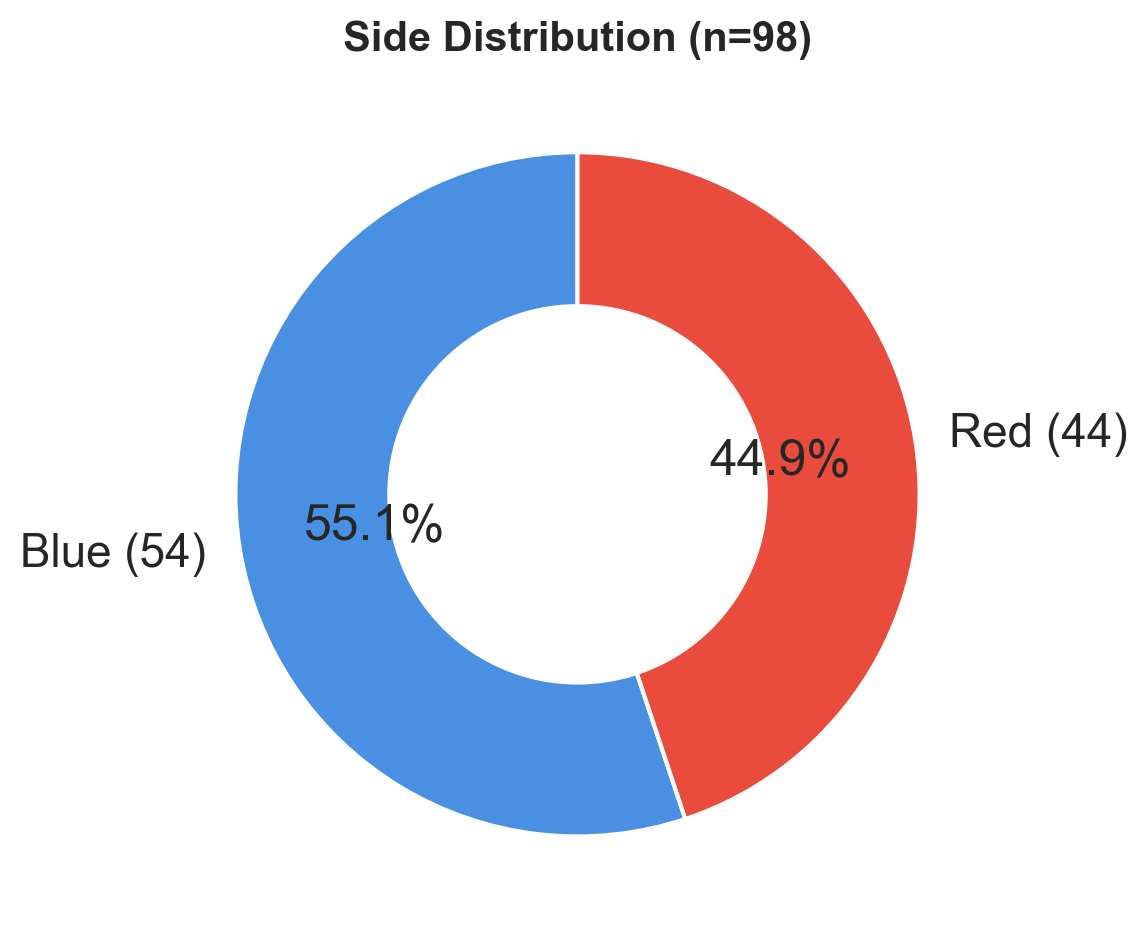

**E4_script_2025-09-13_arutnevjr_ajr_StackedBar.png**

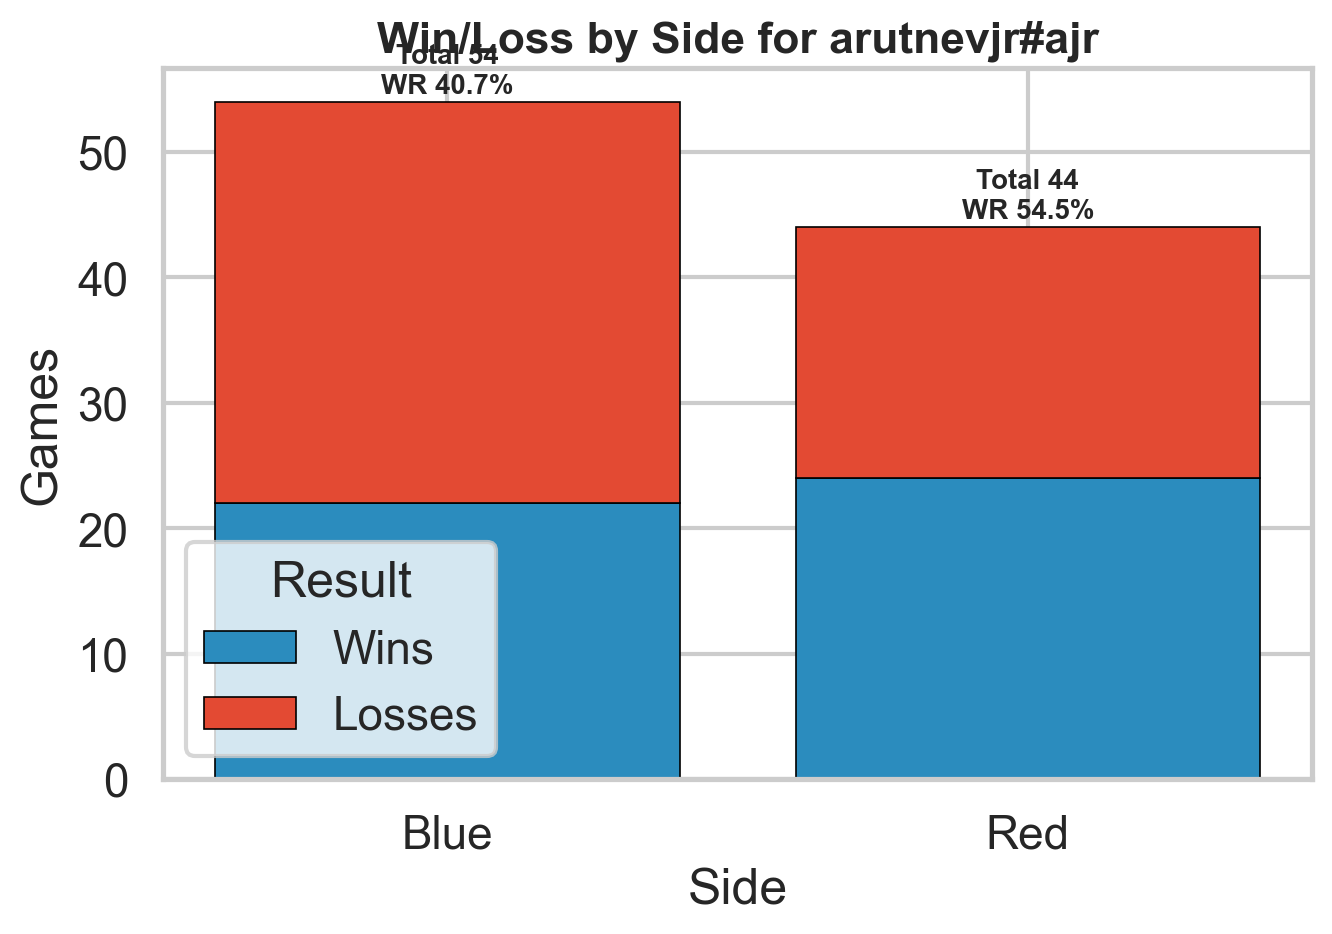

**E4_script_2025-09-13_arutnevjr_ajr_WinrateBar.png**

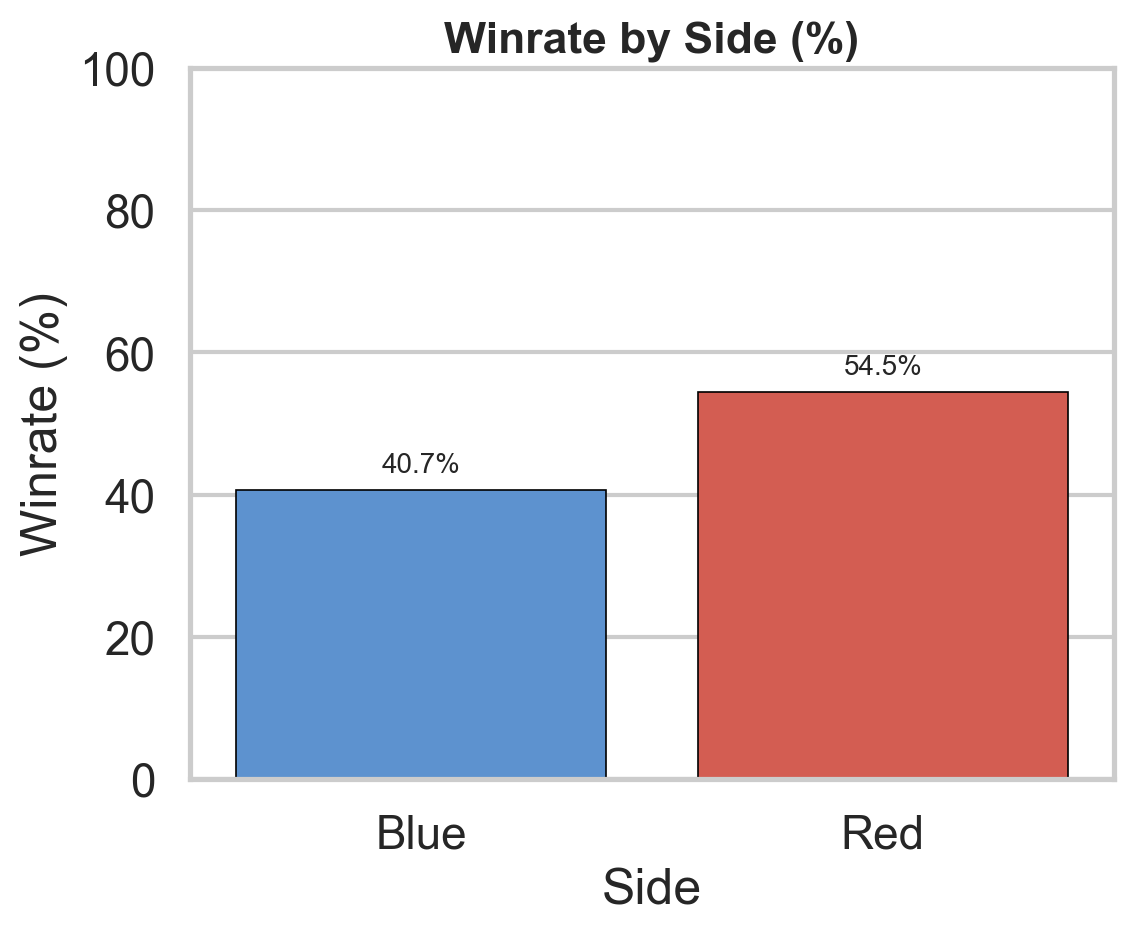

**E4_script_2025-09-23_20-53-54_arutnevjr_ajr_Donut.png**

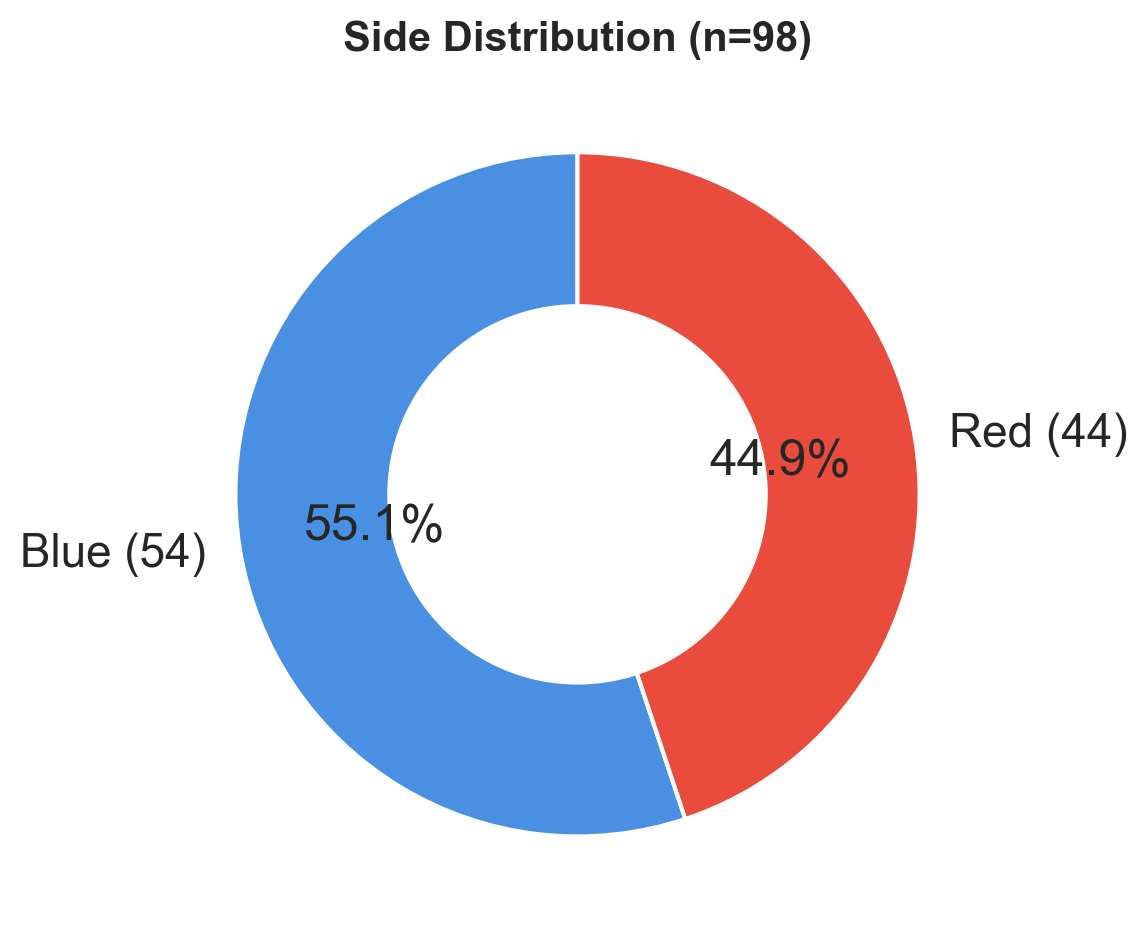

**E4_script_2025-09-23_20-53-54_arutnevjr_ajr_StackedBar.png**

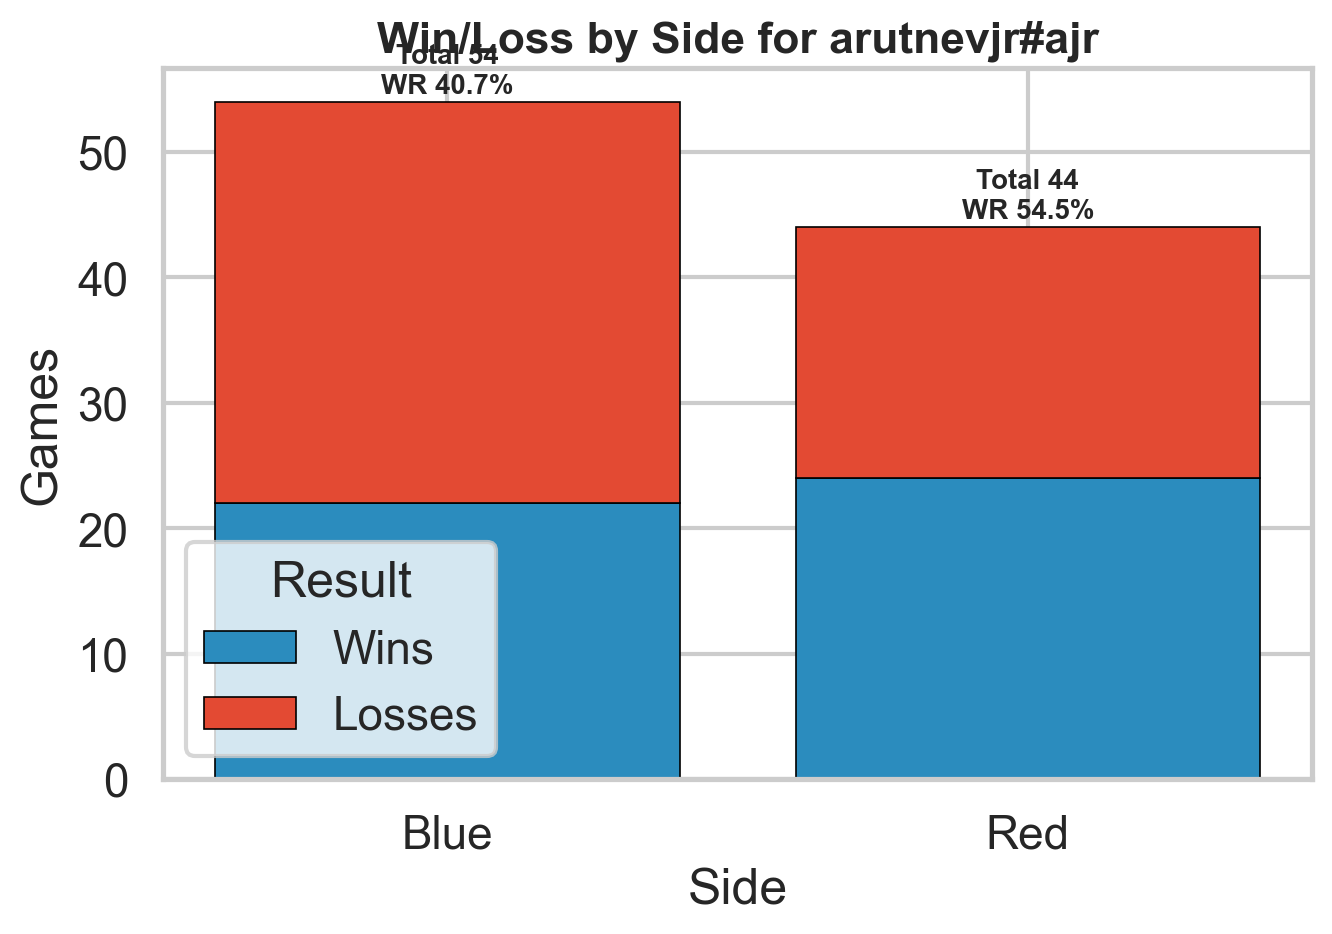

**E4_script_2025-09-23_20-53-54_arutnevjr_ajr_WinrateBar.png**

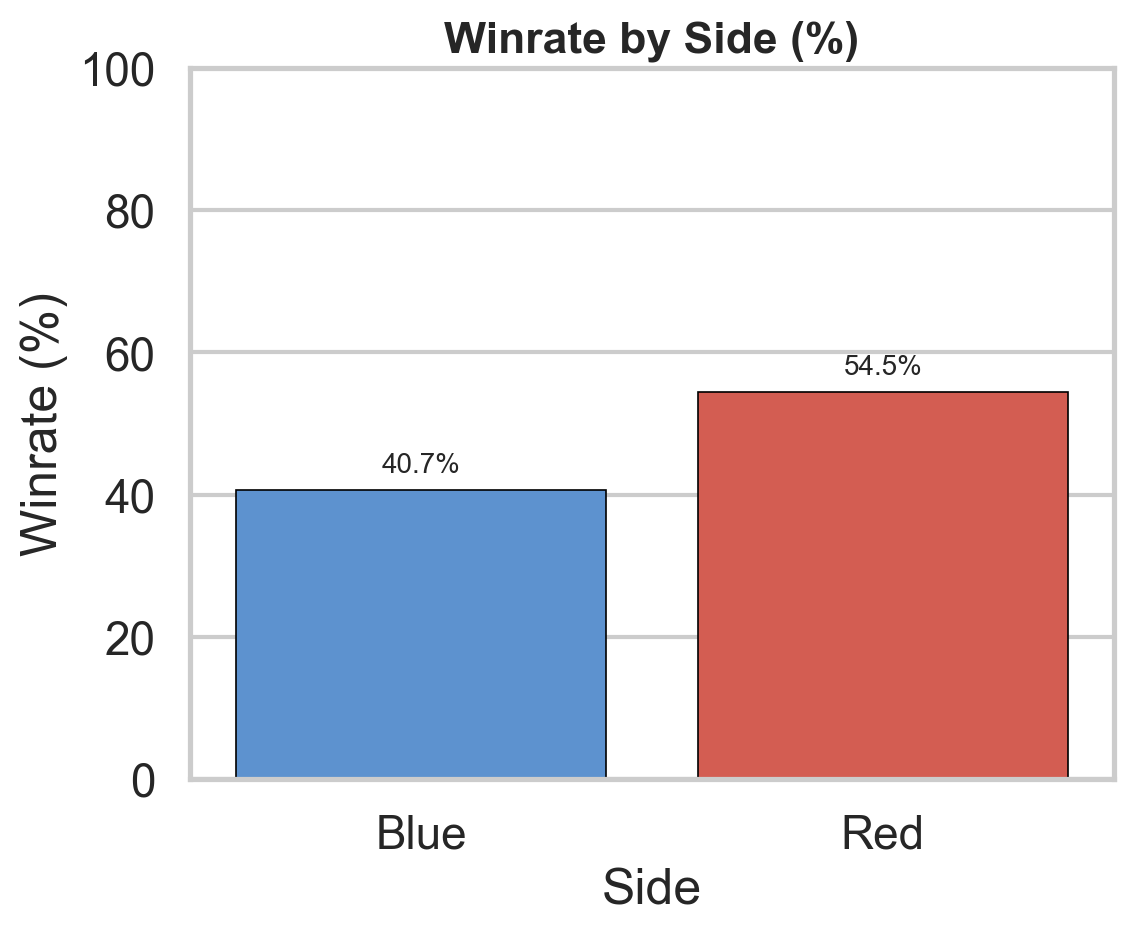

**E4_v1.1_2025-08-13_arutnevjr_ajr_Pie.png**

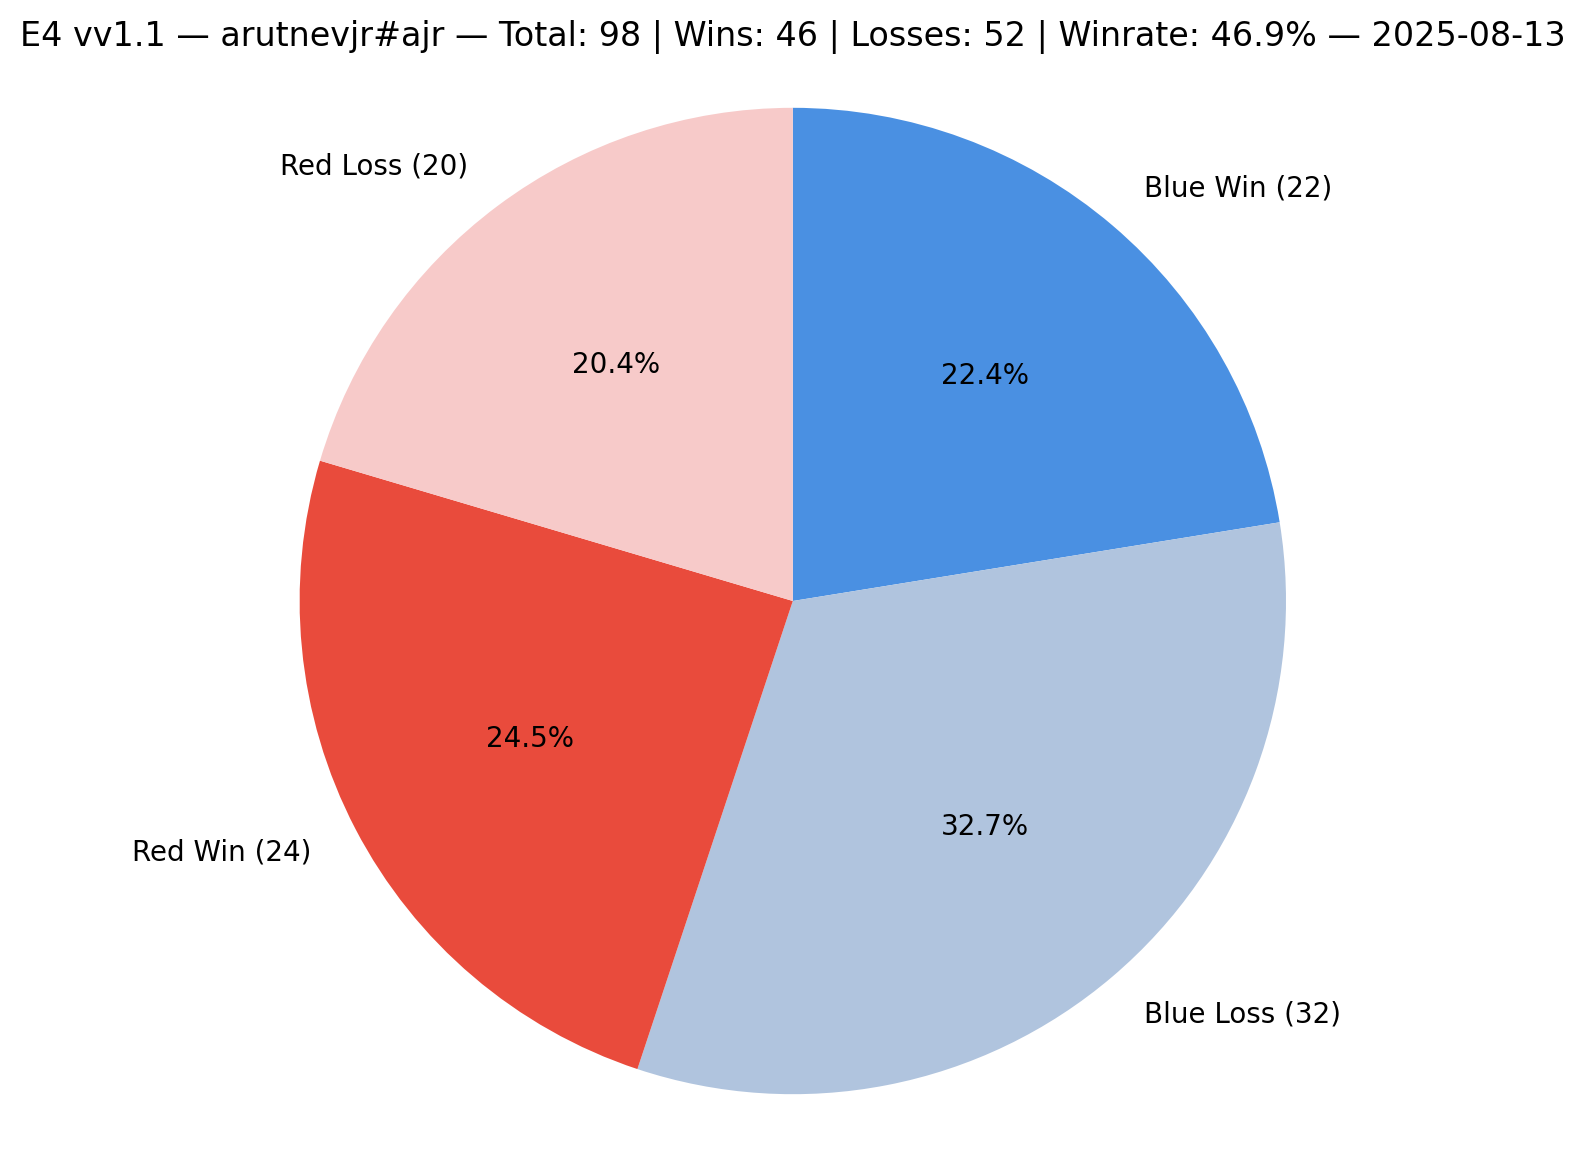

**E4_v1.2_2025-09-23_21-14-50_arutnevjr_ajr_CountBySideWin.png**

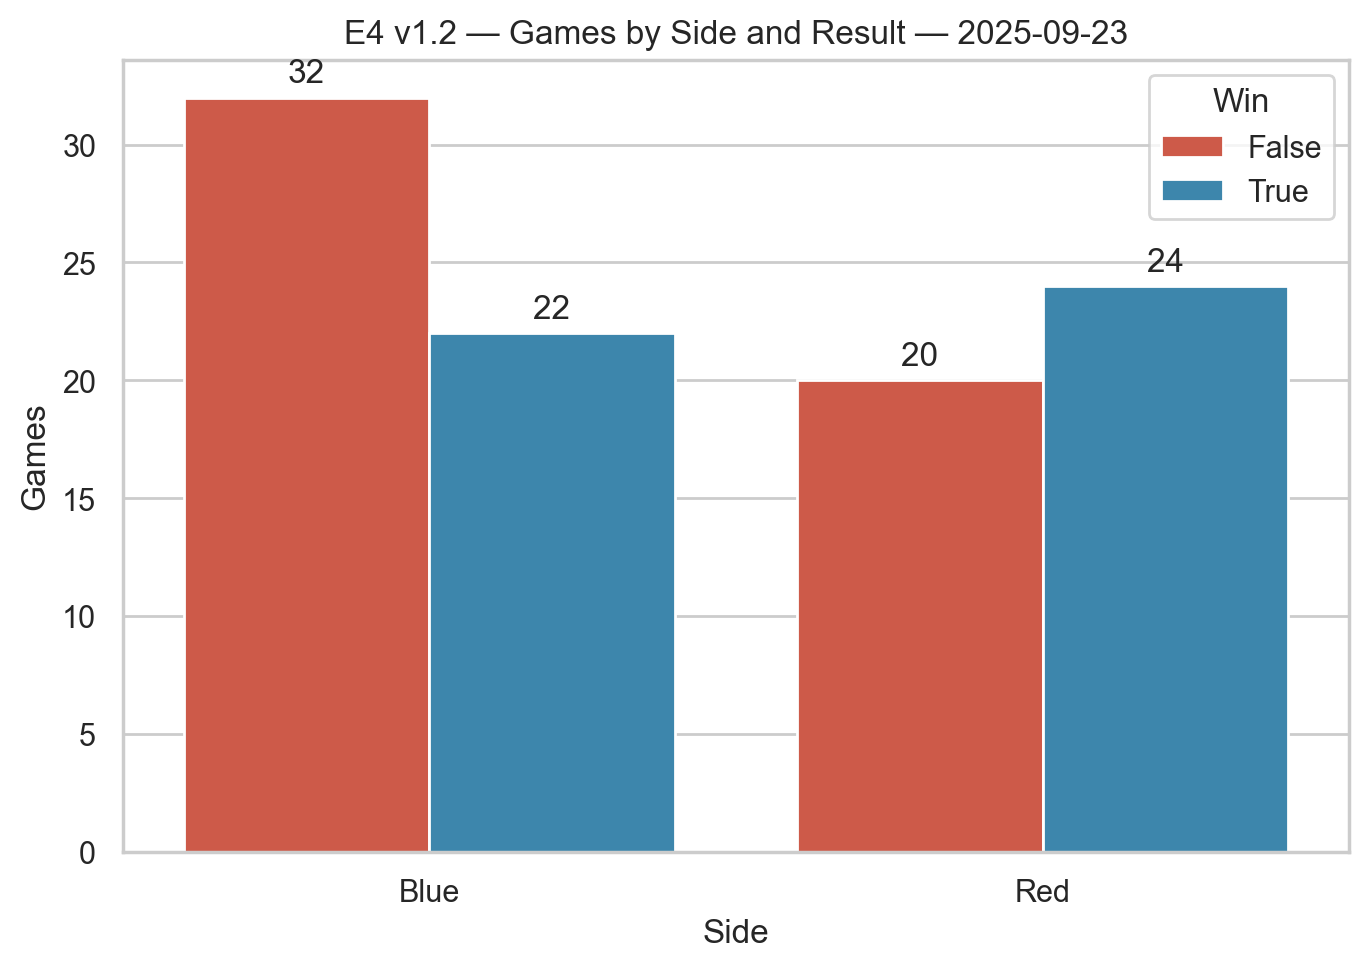

**E4_v1.2_2025-09-23_21-14-50_arutnevjr_ajr_WinrateBar_CI.png**

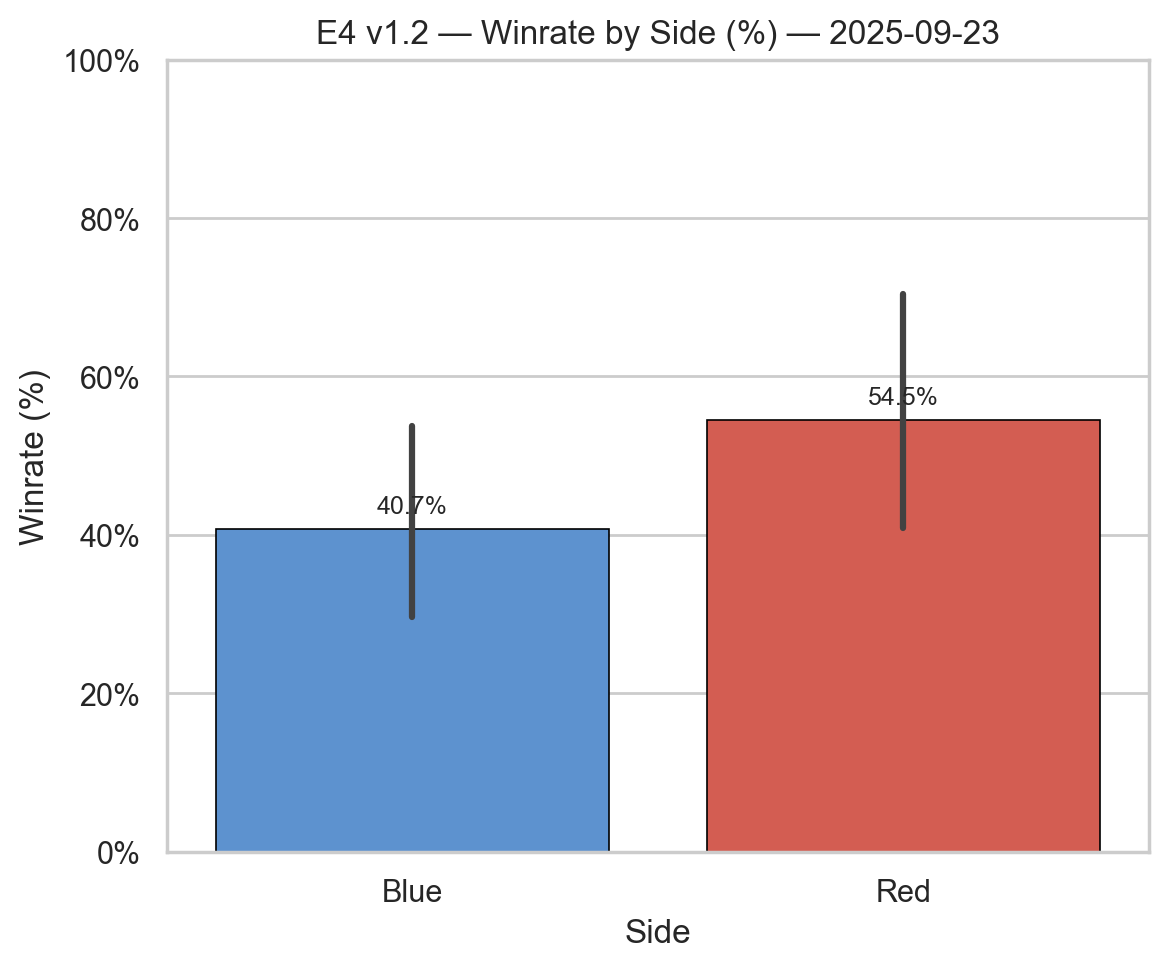

**E4_v1.2_2025-09-23_21-14-50_arutnevjr_ajr_WinratePoint_CI.png**

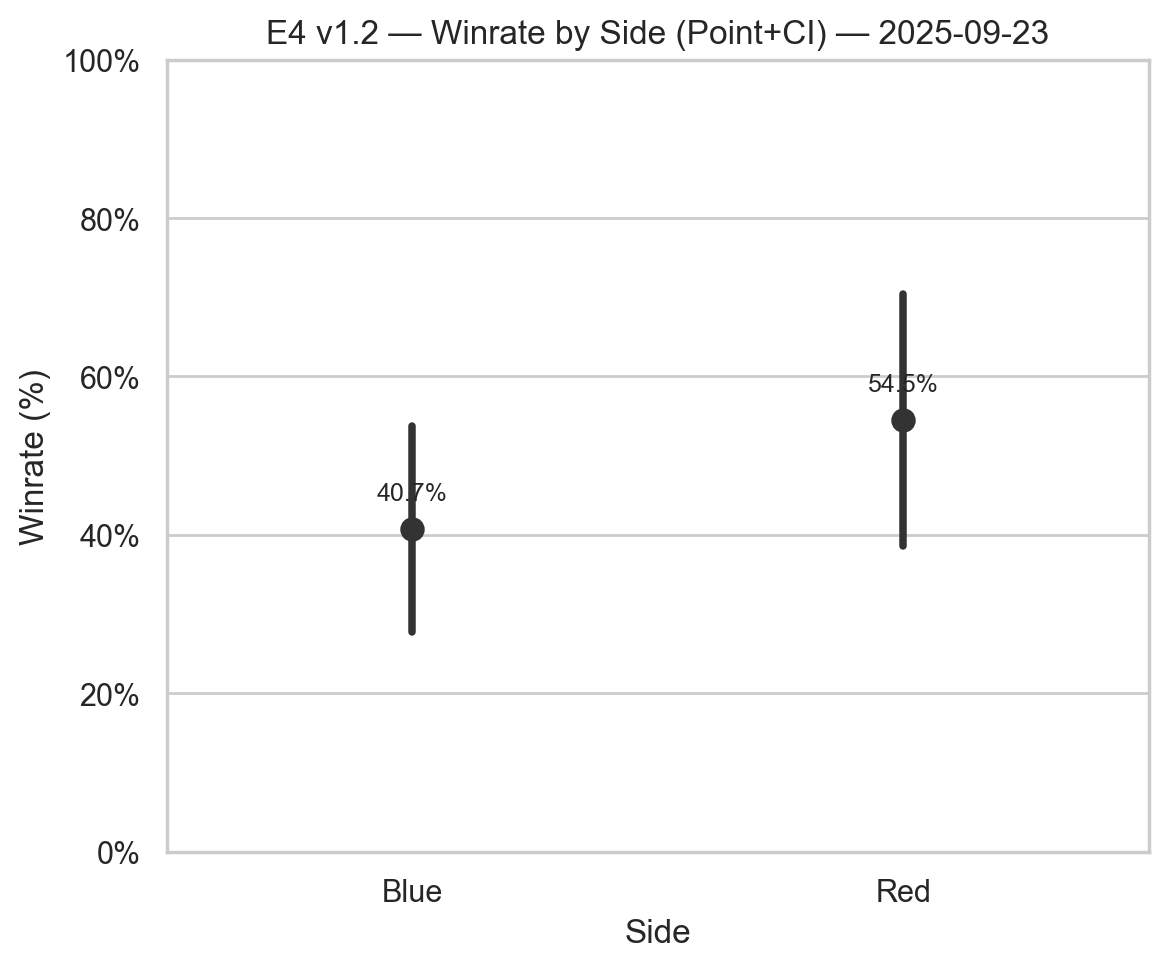

In [7]:
# Display E4 figures (all saved versions)
display_experiment_images('E4', prefix='E4_')

Note: E4 now uses Seaborn gallery-style plots:
- Countplot of Games by Side and Result
- Winrate barplot with 95% CI
- Minimal point plot with 95% CI
These replace the previous pie/donut visuals. Titles include run date and version.

Saved figure: c:\Users\Speazyy\Documents\Faculdade\Mestrado\Tese\Dataset project\LoL-dataset\figures\E4\E4_v1.1_2025-08-13_arutnevjr_ajr_Pie.png


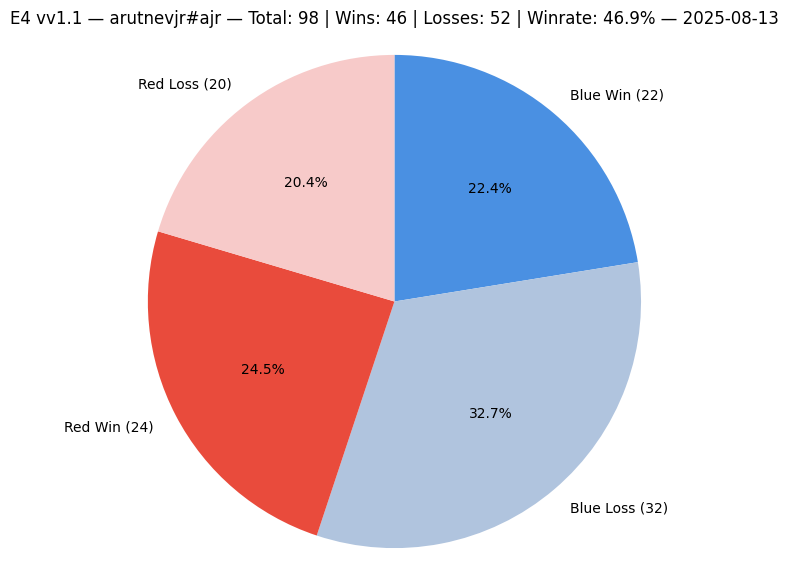

In [ ]:
# Deprecated: Pie/Donut visuals replaced by Seaborn optimal plots above.
print("E4 pie/donut visual deprecated. Use the countplot and CI-based winrate charts above.")

### E5: Player and champion winrates (multi-match)
Notes: Aggregate across matches per player/champion; compute winrates; visualize with bar charts. To be implemented with batched data.

## Findings and next steps
- Figures now embedded directly under each experiment (E1–E4) with versioned filenames; no global gallery.
- Document key learnings per experiment here.
- Track bugs, rate limit issues (429), data corrections, and mapping fixes.
- Outline improvements and follow-up actions for the thesis chapters.